# Graph Representation of Flatland

We present an approach to generating a Directed Graph representation of a Flatland Rail Environment.

Some libraries:
- Python Graph Library NetworkX.
- Javascript 2d Force-Directed Graph layout in d3js
- 3d force layout by Vasco Asturiano.




In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from collections import OrderedDict
from flatland.envs.observations import TreeObsForRailEnv
from flatland.envs.rail_env import RailEnv
from flatland.utils.rendertools import RenderTool
from PIL import Image
import networkx as nx
import json
from numpy import array
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from ipywidgets import Button, HBox, VBox
from flatland.utils.graph_utils import RailEnvGraph, trans_int_to_4x4, trans_int_to_binstr, trans_int_to_nesw, get_rail_transitions_df
from flatland.utils.graph_utils import get_simple_path, plotGraphEnv
import flatland.utils.graph_utils as gu
from flatland.utils.editor import EditorMVC
display(HTML("<style>.container { width:90% !important; }</style>"))

Flask static folder:  /home/jeremy/projects/aicrowd/rl-trains/flatland/notebooks/static


In [3]:
from flatland.envs.rail_generators import rail_from_manual_specifications_generator
from flatland.envs.rail_generators import random_rail_generator, complex_rail_generator, sparse_rail_generator, empty_rail_generator

## Create a simple Flatland Environment from a manual spec


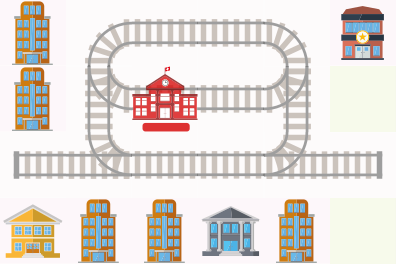

In [4]:
specs = [[(0, 0), (8, 0), (1, 90), (1, 90), (8, 90), (0, 0)],
         [(0, 0), (2, 180), (1, 90), (1, 90), (10, 180), (0, 0)],
         [(7, 270), (10, 270), (1, 90), (1, 90), (2, 90), (7, 90)],
         [(0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (0, 0)]]

env = RailEnv(width=6,
              height=4,
              rail_generator=rail_from_manual_specifications_generator(specs),
              number_of_agents=1,
              obs_builder_object=TreeObsForRailEnv(max_depth=2))

env.reset()

env_renderer = RenderTool(env, gl="PILSVG")
env_renderer.render_env(show=False, show_observations=False, show_agents=False)
aImg = env_renderer.get_image()
Image.fromarray(aImg)

### Create a grid of nodes for structure, then add the direction nodes and edges

We provide a library class which wraps a Rail Environment, and a method to save it in JSON suitable for d3js.

In [5]:
gEnv = RailEnvGraph(env)

gEnv.savejson(filename="test1.json", bKeepId=False)

## HTML to display the graph using d3js and the local javascript file
We provide a Javascript wrapper to invoke the d3js force graph with the JSON file.

In [6]:
%%html
<div id="d3-example"></div>
<script src="./d3_wrapper.js" id="graph2d" graph_file="./test1.json" width=500 height=400 /></script>
 


## Filter to Just the rail nodes - remove most of the grid nodes
- rail nodes (one for each entry direction)
- direction edges
- grid nodes connected to rail nodes
- grid edges between retained grid nodes

In [7]:
G2 = gEnv.graph_rail_grid()

In [8]:
G2b = G2.subgraph([n for n,d in G2.nodes(data=True) if d["type"]=="grid"])

The networkx layouts don't always work that well

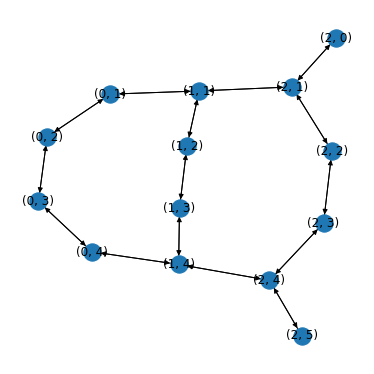

In [9]:
plt.figure(figsize=(5,5))
nx.draw(G2b, with_labels=True)

### Plot the graph over the Flatland render

In [10]:
env.rail.grid.shape

(4, 6)

### Simple Graph "grid nodes" only
Unfortunately these don't capture the constraints over movement across junctions / slips:

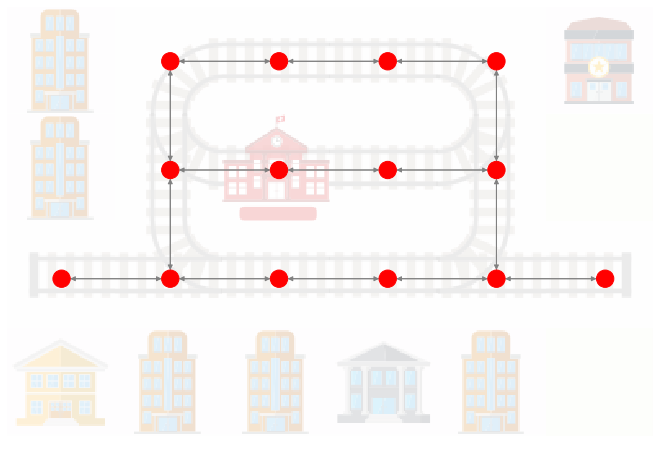

In [11]:
gu.plotGraphEnv(G2, env, aImg, show_nodes=["grid"], show_edges=("grid"), node_colors={"grid":"red"})

### Shortest path makes an illegal turn

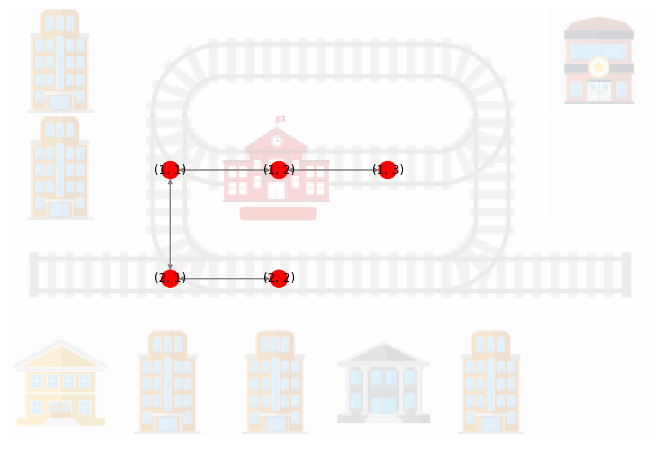

In [12]:
#l_node_path = nx.algorithms.shortest_path(G2b, (2,2,1), (1,3,1))
l_node_path = nx.algorithms.shortest_path(G2b, (2,2), (1,3))
#lnGrid =  [n[:2] for n in l_node_path ]
GPath = nx.induced_subgraph(G2b, l_node_path)
gu.plotGraphEnv(GPath, env, aImg, show_edges=("dir", "hold", "grid"), show_labels=("grid", "rail") ) #, node_colors={"rail":"blue"})

### Introduce direction nodes (called "rail" nodes here)
These have directed edges indicating direction of movement.
There are typically two of them for each "grid" node.

For a junction / slip, we have three - one for each direction of entry.

You should be able to trace the green arrows around a junction.

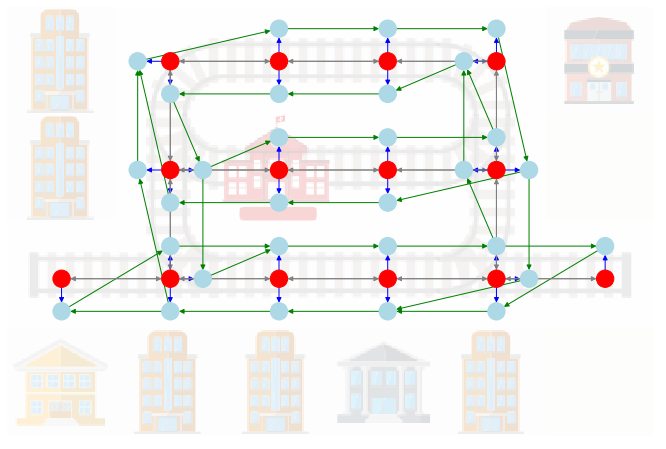

In [13]:
gu.plotGraphEnv(G2, env, aImg, node_colors={"grid":"red", "rail":"lightblue"}, show_edges=("dir", "hold", "grid"))

In [14]:
gEnv.savejson("test2.json")

In [15]:
# Currently broken :(

#%%html
#<iframe src="//localhost:8001/graph1.html?file=test2.json" width=800 height=500>
#</iframe>

### Shortest Path with correct transitions
We can use standard algorithms from NetworkX to find the shortest path.



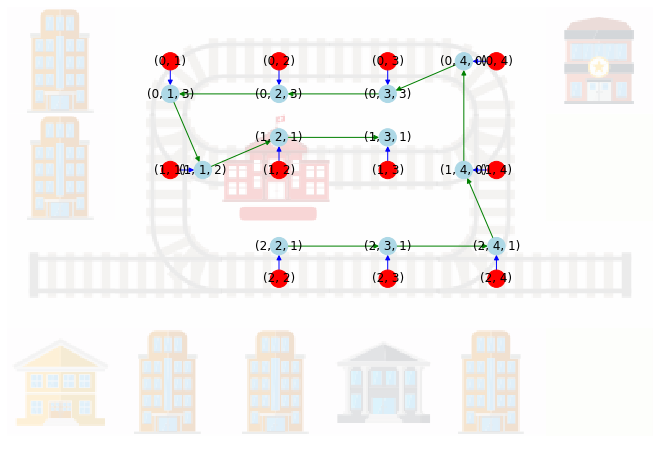

In [16]:
l_node_path = nx.algorithms.shortest_path(G2, (2,2,1), (1,3,1))

lnGrid =  [n[:2] for n in l_node_path ]
#print(l_node_path + lnGrid)
GPath = nx.induced_subgraph(G2, l_node_path + lnGrid)
#print(list(GPath))
gu.plotGraphEnv(GPath, env, aImg, show_edges=("dir", "hold"), show_labels=("grid", "rail") ) #, node_colors={"rail":"blue"})

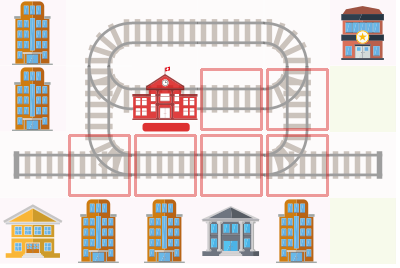

In [17]:
env_renderer.render_env()
display(Image.fromarray(env_renderer.get_image()))

In [18]:
if False:
    #for iPath, tPath in enumerate(nx.algorithms.shortest_simple_paths(G2, (0,25,0), (1,30,1))):
    for iPath, tPath in enumerate(nx.algorithms.shortest_simple_paths(G, u, (*v, 0))):
        if iPath > 5: break
        g2Path = array(tPath)
        plt.scatter(g2Path[:, 1], -g2Path[:, 0], label=str(len(tPath)))
    plt.legend()

In [19]:
len(gEnv.G)

54

### Recreate gEnv and G2

In [20]:
gEnv = RailEnvGraph(env)
G2 = gEnv.graph_rail_grid()
gEnv.savejson(filename="test2.json", alt_graph=G2)

### G3 is grid nodes with rails

In [21]:
G3 = nx.induced_subgraph(G2, [ n for n, d in G2.nodes(data=True) if d["type"]=="grid" ])
gEnv.savejson("test3.json", alt_graph=G3)

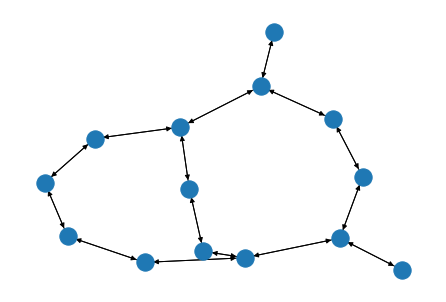

In [22]:
nx.draw(G3); 
#plt.figure(); nx.draw_planar(G3)

In [23]:
#nx.draw(G3, labels={n:str(n) for n in G3.nodes()}, node_color="pink", pos={n:(n[1],-n[0]) for n in G3.nodes()})

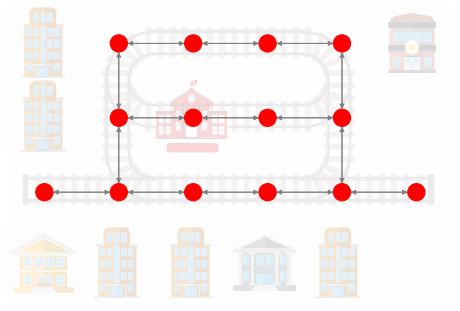

In [24]:
plotGraphEnv(G3, env, aImg, show_edges=("grid"), show_labels=(), figsize=(8,6), node_colors={"grid":"red"})

In [25]:
(G3.nodes(data=True))

NodeDataView({(0, 1): {'type': 'grid'}, (1, 2): {'type': 'grid'}, (1, 3): {'type': 'grid'}, (0, 2): {'type': 'grid'}, (2, 2): {'type': 'grid'}, (1, 4): {'type': 'grid'}, (2, 1): {'type': 'grid'}, (2, 0): {'type': 'grid'}, (2, 4): {'type': 'grid'}, (2, 3): {'type': 'grid'}, (2, 5): {'type': 'grid'}, (0, 4): {'type': 'grid'}, (0, 3): {'type': 'grid'}, (1, 1): {'type': 'grid'}})

In [26]:
G3b = G3.copy()
G3b.nodes(data=True)

NodeDataView({(0, 1): {'type': 'grid'}, (1, 2): {'type': 'grid'}, (1, 3): {'type': 'grid'}, (0, 2): {'type': 'grid'}, (2, 2): {'type': 'grid'}, (1, 4): {'type': 'grid'}, (2, 1): {'type': 'grid'}, (2, 0): {'type': 'grid'}, (2, 4): {'type': 'grid'}, (2, 3): {'type': 'grid'}, (2, 5): {'type': 'grid'}, (0, 4): {'type': 'grid'}, (0, 3): {'type': 'grid'}, (1, 1): {'type': 'grid'}})

In [27]:
G3b.degree

DiDegreeView({(0, 1): 4, (1, 2): 4, (1, 3): 4, (0, 2): 4, (2, 2): 4, (1, 4): 6, (2, 1): 6, (2, 0): 2, (2, 4): 6, (2, 3): 4, (2, 5): 2, (0, 4): 4, (0, 3): 4, (1, 1): 6})

In [28]:
G3b[(0,3)]

AtlasView({(0, 4): {'type': 'grid'}, (0, 2): {'type': 'grid'}})

### G4 - Get the simple paths by selecting the grid nodes of degree 4

In [29]:
# select the grid nodes with exactly 4 edges
G3bDeg = G3b.degree
lnGridSimple = [ n for n, d in G3b.nodes(data=True) if G3b.degree[n]==4 ]
G4 = G3b.subgraph(lnGridSimple)  # copies the nodes + data, and the (grid) edges + data.

In [30]:
G4.nodes(data=True)

NodeDataView({(0, 1): {'type': 'grid'}, (1, 2): {'type': 'grid'}, (1, 3): {'type': 'grid'}, (0, 2): {'type': 'grid'}, (2, 2): {'type': 'grid'}, (2, 3): {'type': 'grid'}, (0, 4): {'type': 'grid'}, (0, 3): {'type': 'grid'}})

In [31]:
G4.edges(data=True)

OutEdgeDataView([((0, 1), (0, 2), {'type': 'grid'}), ((1, 2), (1, 3), {'type': 'grid'}), ((1, 3), (1, 2), {'type': 'grid'}), ((0, 2), (0, 3), {'type': 'grid'}), ((0, 2), (0, 1), {'type': 'grid'}), ((2, 2), (2, 3), {'type': 'grid'}), ((2, 3), (2, 2), {'type': 'grid'}), ((0, 4), (0, 3), {'type': 'grid'}), ((0, 3), (0, 4), {'type': 'grid'}), ((0, 3), (0, 2), {'type': 'grid'})])

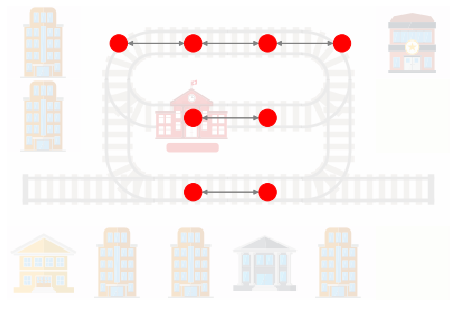

In [32]:
#nx.draw(G4, labels={n:str(n) for n in G4.nodes()}, node_color="pink", pos={n:(n[1],-n[0]) for n in G4.nodes()})
plotGraphEnv(G4, env, aImg, figsize=(8,6), show_edges=("grid"), show_labels=(), node_colors={"grid":"red"})

In [33]:
G4.edges()

gEnv.savejson("test4.json", alt_graph=G4)

### Connected components - grid edges are bidirectional so strong = weak connectivity

In [34]:
list(nx.components.strongly_connected_components(G4))

[{(0, 1), (0, 2), (0, 3), (0, 4)}, {(1, 2), (1, 3)}, {(2, 2), (2, 3)}]

In [35]:
list(nx.components.weakly_connected_components(G4))

[{(0, 1), (0, 2), (0, 3), (0, 4)}, {(1, 2), (1, 3)}, {(2, 2), (2, 3)}]

In [36]:
# "Condensation" doesn't really help us
G4c = nx.components.condensation(G4)
G4c.nodes(data=True)

NodeDataView({0: {'members': {(0, 1), (0, 3), (0, 2), (0, 4)}}, 1: {'members': {(1, 2), (1, 3)}}, 2: {'members': {(2, 3), (2, 2)}}})

In [37]:
def neighbors(G, nbunch, edge_types=None, outer_edge_types=None):
    lnNeighbors = []
    if edge_types is not None:
        if (type(edge_types) is str):
            edge_types = [edge_types]
    else:
        edge_types = ["grid", "hold", "dir"]
    
    if outer_edge_types is not None:
        if (type(outer_edge_types) is str):
            outer_edge_types = [outer_edge_types]
    else:
        outer_edge_types = ["grid", "hold", "dir"]
    
    
    for u in nbunch:
        for v in G.adj[u]:
            edge_type = G.adj[u][v]["type"]
            if edge_type in edge_types:
                lnNeighbors.append(v)
    
    # get all the edges from the original nbunch
    lEdges = [ (u,v,d) for u,v,d in G.edges(nbunch, data=True) if d["type"] in edge_types]
    
    Gneighbours = G.subgraph(lnNeighbors)
    
    # now get the edges between the neighbours
    lEdges += [ (u,v,d) for u,v,d in G.edges(lnNeighbors, data=True) if d["type"] in outer_edge_types and (u in Gneighbours) and (v in Gneighbours)]
    
    return lnNeighbors, lEdges
                

### Find the (rail) neighbours via their (hold) edges, include "dir" edges

In [38]:
print("nodes:", G4.nodes())
lnRails, lEdges = neighbors(G2, G4.nodes(), edge_types="hold", outer_edge_types="dir")
print("rails:", lnRails)
print("edges:", lEdges)

nodes: [(0, 1), (1, 2), (1, 3), (0, 2), (2, 2), (2, 3), (0, 4), (0, 3)]
rails: [(0, 1, 0), (0, 1, 3), (1, 2, 1), (1, 2, 3), (1, 3, 1), (1, 3, 3), (0, 2, 1), (0, 2, 3), (2, 2, 1), (2, 2, 3), (2, 3, 1), (2, 3, 3), (0, 4, 0), (0, 4, 1), (0, 3, 1), (0, 3, 3)]
edges: [((0, 1), (0, 1, 0), {'type': 'hold'}), ((0, 1), (0, 1, 3), {'type': 'hold'}), ((1, 2), (1, 2, 1), {'type': 'hold'}), ((1, 2), (1, 2, 3), {'type': 'hold'}), ((1, 3), (1, 3, 1), {'type': 'hold'}), ((1, 3), (1, 3, 3), {'type': 'hold'}), ((0, 2), (0, 2, 1), {'type': 'hold'}), ((0, 2), (0, 2, 3), {'type': 'hold'}), ((2, 2), (2, 2, 1), {'type': 'hold'}), ((2, 2), (2, 2, 3), {'type': 'hold'}), ((2, 3), (2, 3, 1), {'type': 'hold'}), ((2, 3), (2, 3, 3), {'type': 'hold'}), ((0, 4), (0, 4, 0), {'type': 'hold'}), ((0, 4), (0, 4, 1), {'type': 'hold'}), ((0, 3), (0, 3, 1), {'type': 'hold'}), ((0, 3), (0, 3, 3), {'type': 'hold'}), ((0, 1, 0), (0, 2, 1), {'type': 'dir', 'l': 1}), ((1, 2, 1), (1, 3, 1), {'type': 'dir', 'l': 1}), ((1, 3, 3), (1

In [39]:
G4.nodes()

NodeView(((0, 1), (1, 2), (1, 3), (0, 2), (2, 2), (2, 3), (0, 4), (0, 3)))

In [40]:
list(G4.nodes(data=True))

[((0, 1), {'type': 'grid'}),
 ((1, 2), {'type': 'grid'}),
 ((1, 3), {'type': 'grid'}),
 ((0, 2), {'type': 'grid'}),
 ((2, 2), {'type': 'grid'}),
 ((2, 3), {'type': 'grid'}),
 ((0, 4), {'type': 'grid'}),
 ((0, 3), {'type': 'grid'})]

### G4d - Augment the G4 simple grid paths with their adjacent rails

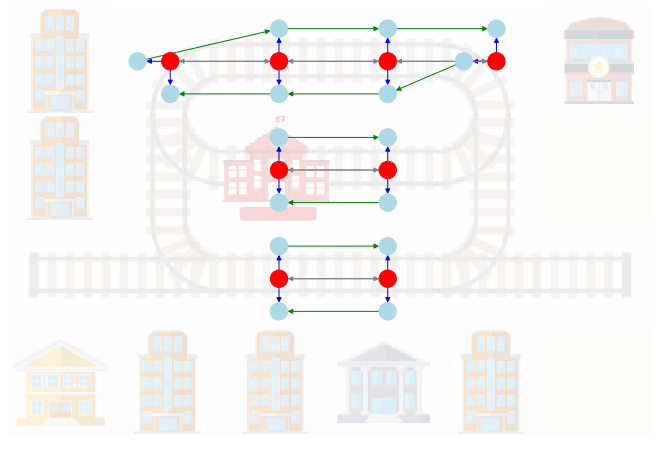

In [41]:
G4d = G4.copy()
#G4d.add_nodes_from(G2.subgraph(lnRails))  # doesn't copy data
# lnRails just has the node ids; use subgraph and .nodes to pull the data from G2.
G4d.add_nodes_from(list(G2.subgraph(lnRails).nodes(data=True)))
G4d.add_edges_from(lEdges)

plotGraphEnv(G4d, env, aImg, show_edges=("dir", "hold", "grid"), )   

### remove / contract the rail / dir paths
- Take a grid path, and two end nodes
- at each end, find its two rail nodes
- one of these has an out dir edge, and is the start of a dir chain
- The other one has an in dir edge, and is the end of a dir chain


In [42]:
u = (0,1)
for v in G2.neighbors(u): 
#for v in G2.adj[u]:
    print(v, G2.adj[u][v])
G2.adj[u]

(0, 1, 0) {'type': 'hold'}
(0, 1, 3) {'type': 'hold'}
(0, 2) {'type': 'grid'}
(1, 1) {'type': 'grid'}


AtlasView({(0, 1, 0): {'type': 'hold'}, (0, 1, 3): {'type': 'hold'}, (0, 2): {'type': 'grid'}, (1, 1): {'type': 'grid'}})

In [43]:
list(G2.neighbors(u))

[(0, 1, 0), (0, 1, 3), (0, 2), (1, 1)]

### G3c = G3b; contract the grid simple path-ends

### G5 = G2; contract the rail simple path-ends

In [44]:
if False:

    G3c = G3b.copy() # grid nodes 
    G4e = G4d.copy() # the simple paths augmented with rails
    G5 = G2.copy() # the full graph, mutable, so we can remove things:
    #print (G4.degree)
    for nSet in nx.components.strongly_connected_components(G4): # G4 is the grid simple paths
        #print("comp:", nSet)
        igComp = nx.induced_subgraph(G4,nSet)
        #print("deg:", igComp.degree)
        lnInner = [ n for n,d in igComp.degree if d==4 ]
        #print("inner:", lnInner)

        #igCompRail = nx.induced_subgraph(G4d, )
        #lnInnerRails = [ n for n,d in nx.induce]

        lnEnds = [ n for n,d in igComp.degree if d==2 ]
        #print("ends:", lnEnds)

        # Remove the inner nodes
        G3c.remove_nodes_from(lnInner)
        G5.remove_nodes_from(lnInner)


        lnPathStart = []
        lnPathEnd = []

        for grid_end in lnEnds: # look at each end of this grid path
            #grid_end = lnEnds[0] # look at the first end
            print("grid_end", grid_end)
            path_start = None
            for rail_end in G4e.adj[grid_end]: # look at the rail at this end
                #print("rail_end", rail_end, G4e.adj[grid_end][rail_end])
                if G4e.adj[grid_end][rail_end]["type"] == "hold":  # select rail, discard grid
                    print(rail_end)
                    outedges = G4e.edges([rail_end])
                    if len(outedges)==1:
                        #print("outedges", outedges)
                        lnPathStart.append(rail_end)
                    else:
                        lnPathEnd.append(rail_end)

        print("pathStart:", lnPathStart)
        print("pathEnd:", lnPathEnd)

        lnPathEnd.reverse()  # the ends are the opposite order to the starts...

        for nPathStart in lnPathStart:
            lnPath = get_simple_path(G4d, nPathStart)
            print("lnPath", lnPath)
            if len(lnPath)>2:
                G5.remove_nodes_from(lnPath[1:-1])
            # Join the start and end of the rail chain into a single node
            G5 = nx.minors.contracted_nodes(G5, lnPath[0], lnPath[-1], self_loops=False)

        # Join up (identify, ie make identical) the ends of the grid chain into a single node
        G3c = nx.minors.contracted_nodes(G3c, *lnEnds, self_loops=False)
        G5 = nx.minors.contracted_nodes(G5, *lnEnds, self_loops=False) 



        # We've now joined up the grid nodes.   We still need to add back in the rail nodes, hold edges, and dir edges.

    

In [45]:
G5 = gEnv.reduce_simple_paths()

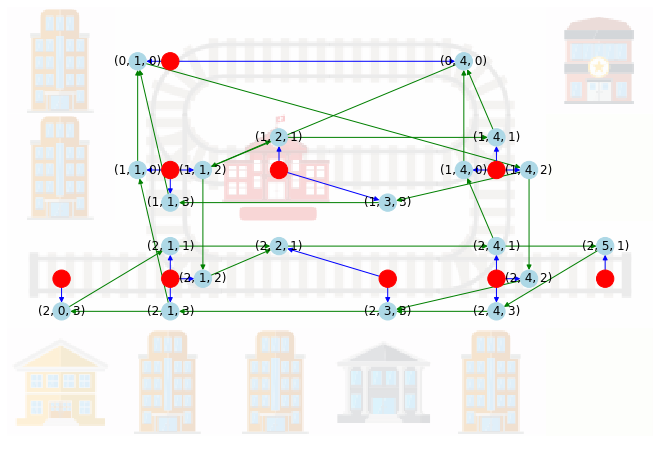

In [46]:
plotGraphEnv(G5, env, aImg, show_edges=["dir", "hold"], show_labels=["rail"])

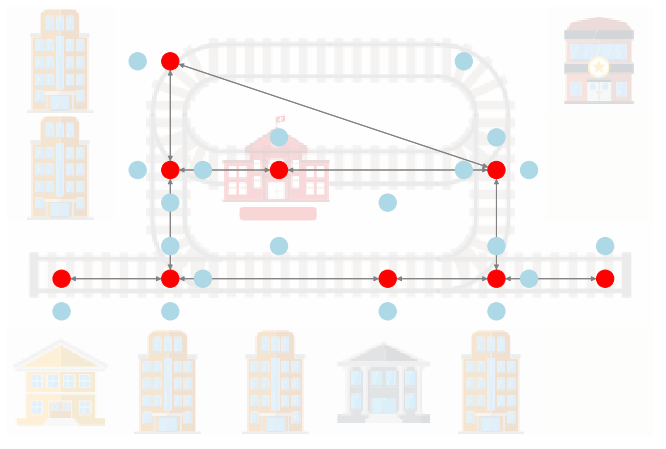

In [47]:
plotGraphEnv(G5, env, aImg, show_edges=["grid"])

In [48]:
gEnv.savejson("test5.json", alt_graph=G5)


In [49]:
[ n for n, d in G5.nodes(data=True) if d["type"]=="grid" ]

[(0, 1), (1, 1), (1, 2), (1, 4), (2, 0), (2, 1), (2, 3), (2, 4), (2, 5)]

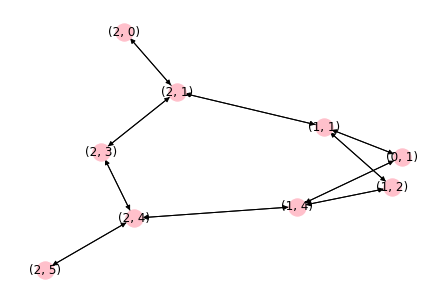

In [50]:
G5b = nx.induced_subgraph(G5, [ n for n, d in G5.nodes(data=True) if d["type"]=="grid" ])
nx.draw(G5b, with_labels=True, node_color="pink")


In [51]:
G5.succ[(0,1,0)]

AtlasView({(1, 4, 2): {'type': 'dir', 'l': 4}})

In [52]:
G5.pred[(0,1,0)]

AtlasView({(1, 1, 0): {'type': 'dir', 'l': 1}, (1, 1, 3): {'type': 'dir', 'l': 1}, (0, 1): {'type': 'hold', 'l': 4}})

In [53]:
for n in G5.adjacency():
    print (n)

((0, 1, 0), {(1, 4, 2): {'type': 'dir', 'l': 4}})
((0, 4, 0), {(1, 1, 2): {'type': 'dir', 'l': 4}})
((1, 1, 0), {(0, 1, 0): {'type': 'dir', 'l': 1}})
((1, 1, 2), {(1, 2, 1): {'type': 'dir', 'l': 1}, (2, 1, 2): {'type': 'dir', 'l': 1}})
((1, 1, 3), {(0, 1, 0): {'type': 'dir', 'l': 1}})
((1, 2, 1), {(1, 4, 1): {'type': 'dir', 'l': 2}})
((1, 3, 3), {(1, 1, 3): {'type': 'dir', 'l': 2}})
((1, 4, 0), {(0, 4, 0): {'type': 'dir', 'l': 1}})
((1, 4, 1), {(0, 4, 0): {'type': 'dir', 'l': 1}})
((1, 4, 2), {(2, 4, 2): {'type': 'dir', 'l': 1}, (1, 3, 3): {'type': 'dir', 'l': 1}})
((2, 0, 3), {(2, 1, 1): {'type': 'dir', 'l': 1}})
((2, 1, 1), {(2, 2, 1): {'type': 'dir', 'l': 1}})
((2, 1, 2), {(2, 2, 1): {'type': 'dir', 'l': 1}})
((2, 1, 3), {(1, 1, 0): {'type': 'dir', 'l': 1}, (2, 0, 3): {'type': 'dir', 'l': 1}})
((2, 2, 1), {(2, 4, 1): {'type': 'dir', 'l': 2}})
((2, 3, 3), {(2, 1, 3): {'type': 'dir', 'l': 2}})
((2, 4, 1), {(1, 4, 0): {'type': 'dir', 'l': 1}, (2, 5, 1): {'type': 'dir', 'l': 1}})
((2, 4

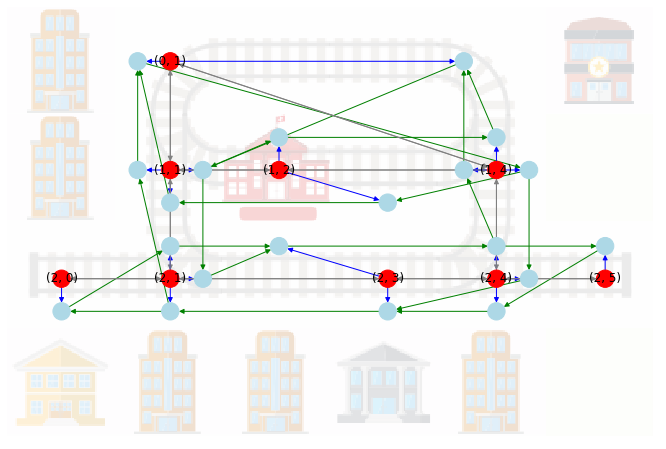

In [54]:
plotGraphEnv(G5, env, aImg, show_edges=("dir", "hold", "grid"), show_labels="grid", node_colors={"grid":"red", "rail":"lightblue"})   

In [55]:
#plotGraphEnv(G3c, env, aImg, node_colors={"grid":"red"}, show_edges=["grid", "hold", "dir"])   
#nx.draw_networkx_edge_labels(G3c, edge_labels = { (u,v):d["type"] for u,v,d in G3c.edges(data=True)})

In [56]:
#G5 = G2.edge_subgraph([ (u,v) for u,v,d in G2.edges(data=True) if (u in G3c) and (v in G3c) ])
#plotGraphEnv(G5, env, aImg, show_edges=("dir", "hold", "grid"), show_labels="grid", node_colors={"grid":"red", "rail":"lightblue"})   

## Try a larger env

In [57]:
if False:
    width = 50  # With of map
    height = 50  # Height of map
    nr_trains = 5  # Number of trains that have an assigned task in the env
    cities_in_map = 8  # Number of cities where agents can start or end
if True:
    width = 30  # With of map
    height = 30  # Height of map
    nr_trains = 5  # Number of trains that have an assigned task in the env
    cities_in_map = 3  # Number of cities where agents can start or end

if True:
    width = 80  # With of map
    height = 80  # Height of map
    nr_trains = 15  # Number of trains that have an assigned task in the env
    cities_in_map = 15  # Number of cities where agents can start or end

    
    
seed = 14  # Random seed
grid_distribution_of_cities = True  # Type of city distribution, if False cities are randomly placed
max_rails_between_cities = 2  # Max number of tracks allowed between cities. This is number of entry point to a city
max_rail_in_cities = 6  # Max number of parallel tracks within a city, representing a realistic trainstation

rail_generator = sparse_rail_generator(max_num_cities=cities_in_map,
                                       seed=seed,
                                       grid_mode=grid_distribution_of_cities,
                                       max_rails_between_cities=max_rails_between_cities,
                                       max_rails_in_city=max_rail_in_cities,
                                       )

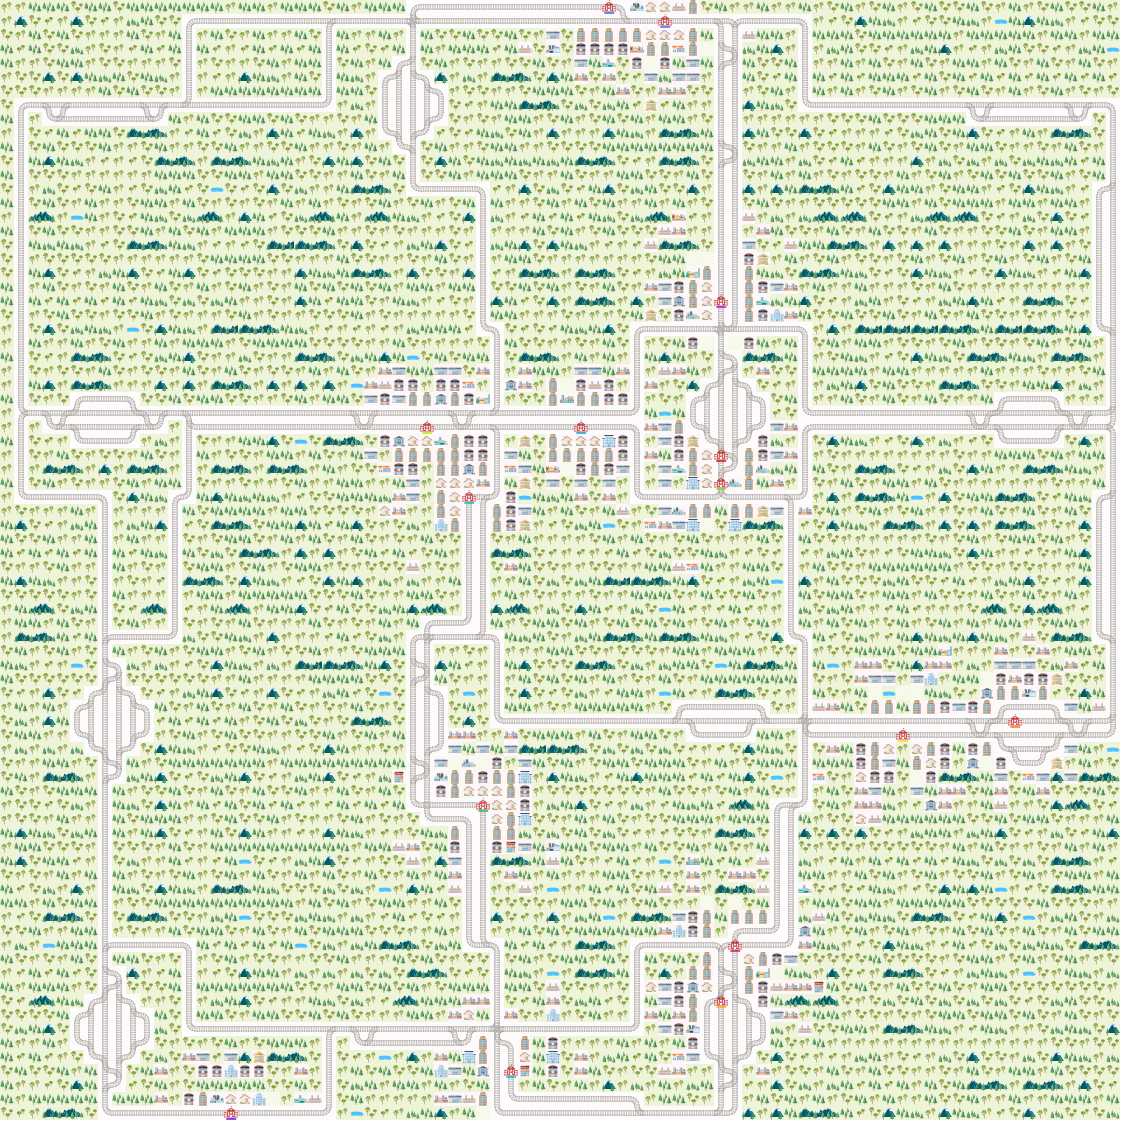

In [58]:
random.seed(102)
np.random.seed(102)


# Example generate a random rail
env2 = RailEnv(width=width,
              height=height,
              rail_generator=rail_generator,
              # rail_generator=complex_rail_generator(nr_start_goal=3, min_dist=5),
              number_of_agents=nr_trains,
              obs_builder_object=TreeObsForRailEnv(max_depth=2))

env2.reset()

env_renderer = RenderTool(env2, gl="PILSVG",  screen_width=1200, screen_height=1200)
env_renderer.render_env(show=False, show_observations=False,)
aImg = env_renderer.gl.get_image()
Image.fromarray(aImg)

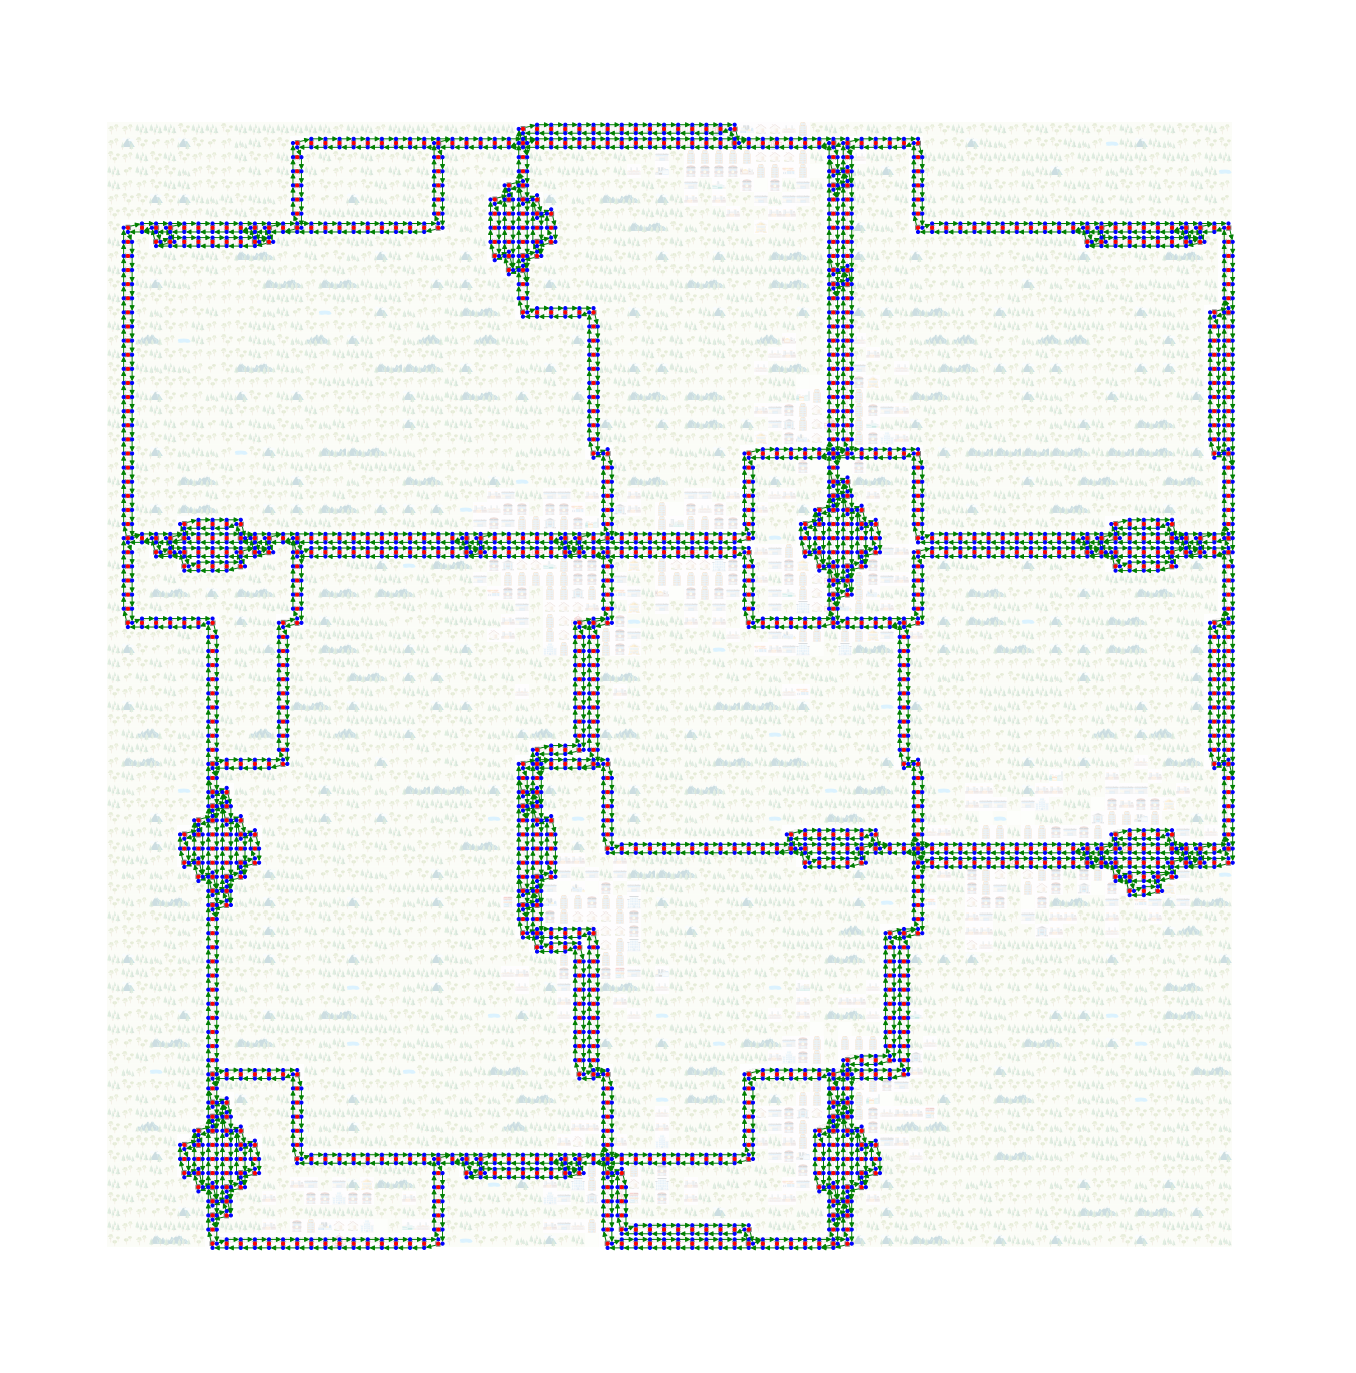

In [59]:
# Create a grid of nodes matching (isomorphic to) the env rail grid
gEnv2 = RailEnvGraph(env2)

#plotGraphEnv(gEnv2.G, env2, aImg, figsize=(20,20))
gu.plotGraphEnv(gEnv2.graph_rail_grid(), env2, aImg, figsize=(25,25), node_size=10,
                node_colors={"rail":"blue", "grid":"red"},
                edge_colors={"hold":"gray", "dir":"green"},
                show_nodes=("rail", "grid"),
                show_edges=("dir", "hold")
               )


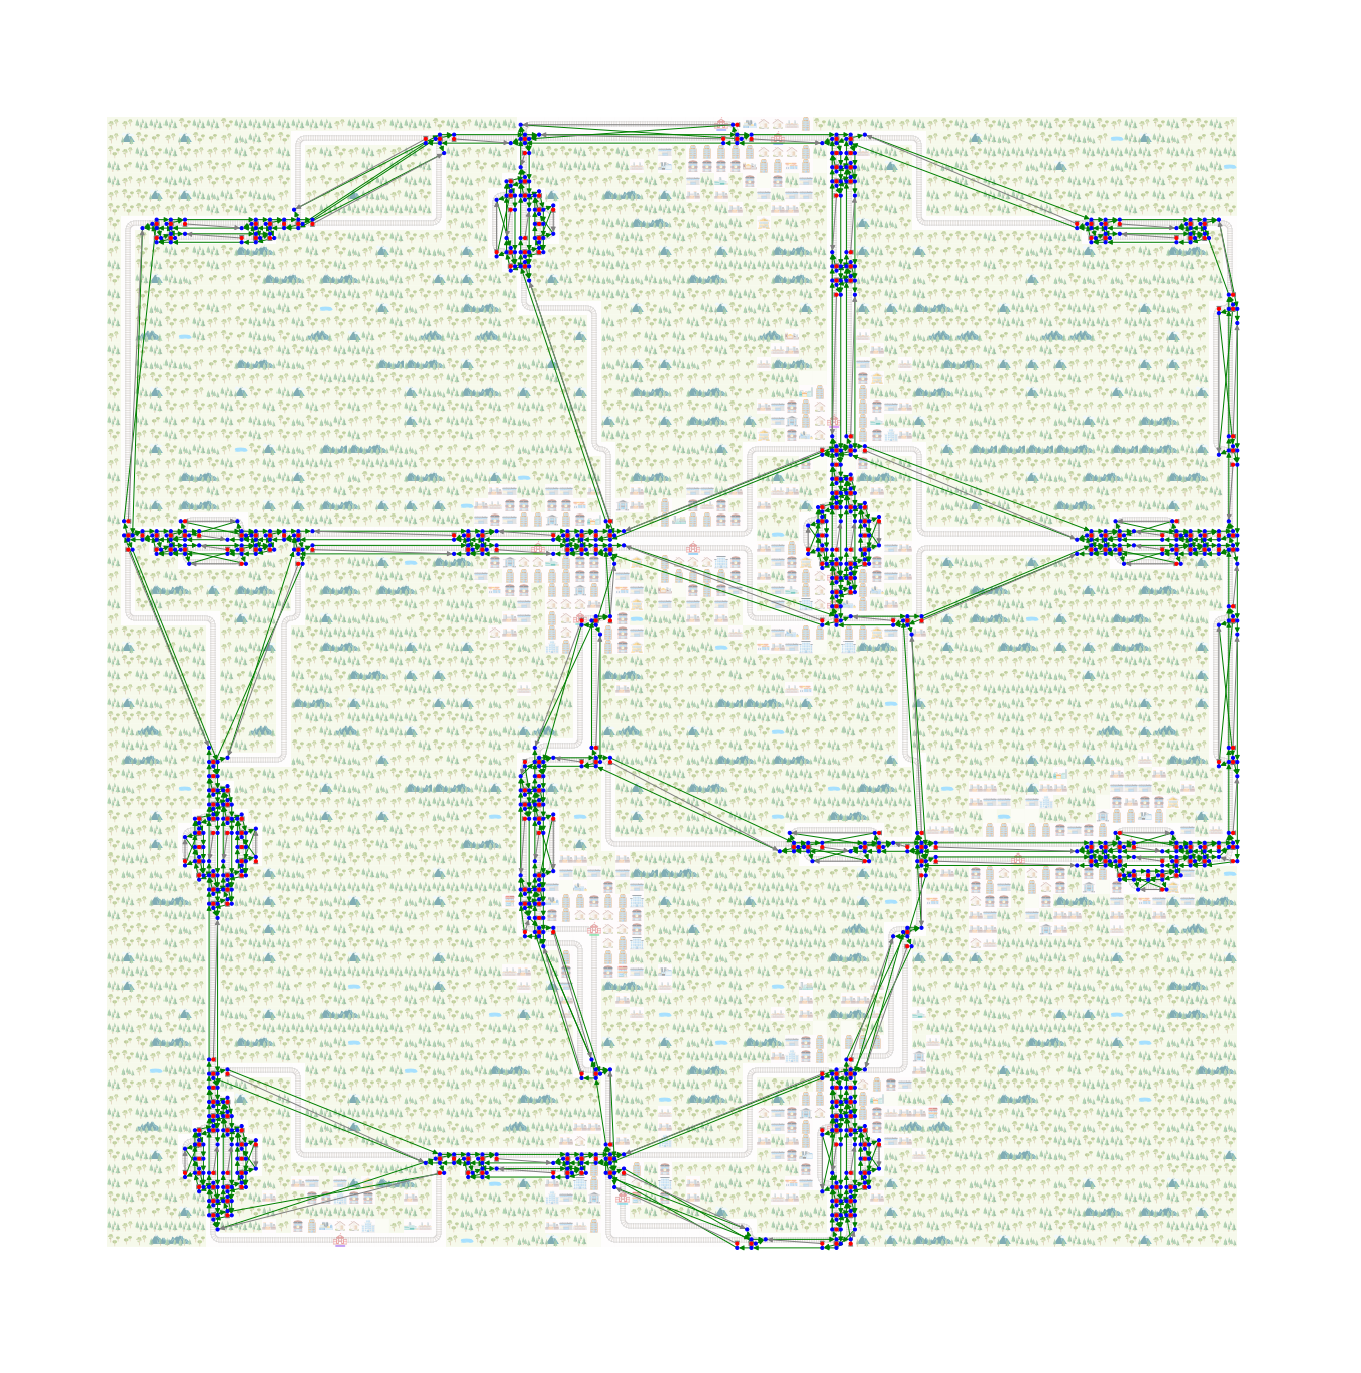

In [60]:
#gEnv2.savejson("test-large1.json")
G5e2 = gEnv2.reduce_simple_paths()

gu.plotGraphEnv(G5e2, env2, aImg, figsize=(25,25), node_size=10,
                node_colors={"rail":"blue", "grid":"red"},
                edge_colors={"hold":"gray", "dir":"green"},
                show_nodes=("rail", "grid"),
                show_edges=("dir", "hold"),
                alpha_img=0.5
               )


In [61]:
gEnv2.savejson("test-large-red.json", alt_graph=G5e2)

In [62]:
gEnv2.savejson("test-large.json", alt_graph=gEnv2.graph_rail_grid())

## Generate some shortest paths between different start, ends

In [63]:
G = G5e2  # with contracted simple paths
nAgents=20

lGpaths = []

if False:
    for agent in env2.agents[:nAgents]:
    
    
        nStart = agent.initial_position
        nEnd = agent.target
        lnStartDir = []

        if nStart in G and nEnd in G:
            lnNeighbours = list(G.neighbors(nStart))
            for nNbr in lnNeighbours:
                if len(nNbr)==3:
                    lnStartDir.append(nNbr)



            lnEndDir = []
            lnNeighbours = list(G.neighbors(nEnd))
            for nNbr in lnNeighbours:
                if len(nNbr)==3:
                    lnEndDir.append(nNbr)

            print(nStart, lnStartDir, nEnd, lnEndDir)
        else:
            print("Start / end not in graph:", nStart, nEnd)

            
    
    
        for nStartDir in lnStartDir[:1]:
            for nEndDir in lnEndDir[:1]:
                lnPath = nx.algorithms.shortest_path(G, source=nStartDir, target=nEndDir)
                Gpath = nx.induced_subgraph(G, lnPath)
                lGpaths.append(Gpath)
                print(len(lnPath))

### Look for some longer edges

In [64]:
[ (u, v, d["l"]) for u,v,d in G.edges(data=True) if "l" in d and d["l"] > 1 ][:10]

[((0, 29, 0), (1, 44, 2), 16),
 ((0, 44, 0), (1, 29, 2), 16),
 ((1, 22, 3), (7, 13, 2), 15),
 ((1, 24, 1), (1, 29, 1), 5),
 ((1, 28, 3), (1, 23, 3), 5),
 ((1, 30, 1), (1, 44, 1), 14),
 ((1, 43, 3), (1, 29, 3), 14),
 ((1, 45, 1), (1, 51, 1), 6),
 ((1, 50, 3), (1, 44, 3), 6),
 ((1, 53, 1), (7, 69, 1), 22)]

In [95]:
import random
random.seed(23)
nAgents=100

lnRails = [ n for n,d in G.nodes(data=True) if d["type"]=="rail"]
lnStart = []
lnTarget = []
llnPaths = []
for i in range(nAgents):
    nRailStart = random.choice(lnRails)
    nRailEnd = random.choice(lnRails)
    lnPath = nx.algorithms.shortest_path(G, source=nRailStart, target=nRailEnd, weight="l")
    Gpath = nx.induced_subgraph(G, lnPath)
    llnPaths.append(lnPath)
    lGpaths.append(Gpath)
    lnStart.append(nRailStart)
    lnTarget.append(nRailEnd)
                
Gpaths = nx.compose_all(lGpaths)

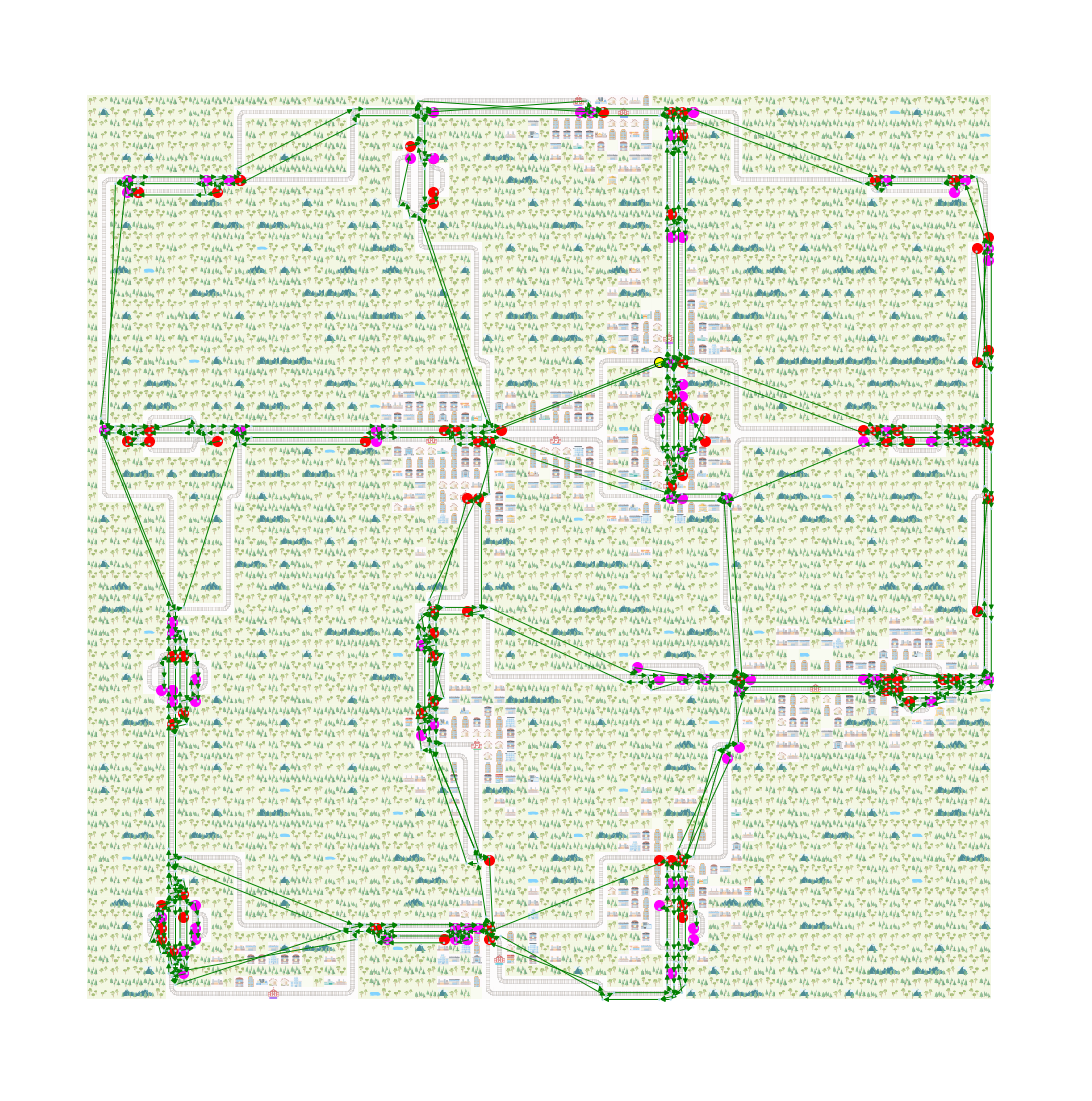

In [96]:
gu.plotGraphEnv(Gpaths, env2, aImg, node_size=2, figsize=(20,20), alpha_img=0.7)

for nStart, nEnd in zip(lnStart, lnTarget):
    #nStart = agent.initial_position
    #nEnd = agent.target
    plt.scatter(nStart[1], -nStart[0], color="r", s=100)
    plt.scatter(nEnd[1], -nEnd[0], color="magenta", s=100)
            
plt.scatter(50,-23, color="yellow", edgecolors="black", s=100)

### Create grid paths from the rail paths

The grid path is the grid nodes corresponding to the rail nodes 

In [97]:
llnGridPaths = []
for lnPath in llnPaths:
    lnGridPath = []
    for n in lnPath:
        # find the grid node for this rail node
        nGrid = [ n for n, d in G.pred[n].items() if d["type"]=="hold" ][0]
        lnGridPath.append(nGrid)
    llnGridPaths.append(lnGridPath)
    

In [98]:
len(llnGridPaths)

100

### Resource usage

Text(0.5, 1.0, 'Rail Resource usage through time')

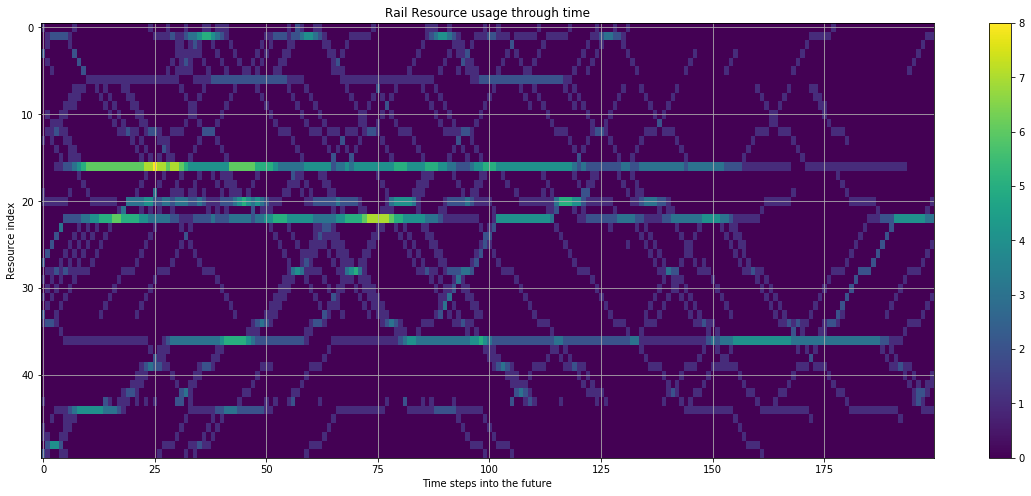

In [101]:
dResource = OrderedDict()  # the grid nodes, each with a vector of utilisation through time
dlRails = OrderedDict()    # For each grid node, a list of direction nodes used
dg2Dirs = OrderedDict()    # For each grid node, a matrix of 4 x vectors of utilisation, one for each direction, indexed as above

nSteps=500
for lnGridPath, lnPath in list(zip(llnGridPaths, llnPaths))[:]:
    t=0
    
    # Create a resource for each grid node n
    # increment a counter for each step it is occupied by this agent
    for i in range(len(lnGridPath)):
        n = lnGridPath[i]
        nRail = lnPath[i]
        #print(i,n)
        if n not in dResource:
            dResource[n] = np.zeros(nSteps)
            dlRails[n] = [nRail] # list of rail nodes used for entry
            dg2Dirs[n] = np.zeros((nSteps, 4)) # timesteps x "directions" (really, entry nodes)
            #print(n, nRail)
        
        if nRail not in dlRails[n]:
            dlRails[n].append(nRail)
        iRail = dlRails[n].index(nRail)
        
        d = G.nodes()[n]
        if "l" in d:
            weight = d["l"]
        else:
            weight = 1
        
        g2Dirs = dg2Dirs[n]
        for t2 in range(t, t+weight):
            # increment the resource utilisation
            dResource[n][t2] += 1
            
            # Increment the direction utilisation
            
            g2Dirs[t2, iRail] += 1
        t += weight

a2ResSteps = np.stack(list(dResource.values()))
a3ResDirSteps = np.stack(list(dg2Dirs.values()))

plt.figure(figsize=(20,8))
plt.imshow(a2ResSteps[:50,:200], aspect="auto")
#plt.scatter(35, 13, color="red")
plt.xlabel("Time steps into the future")
plt.ylabel("Resource index")
plt.colorbar()
plt.grid()
plt.title("Rail Resource usage through time")

In [102]:
sum([ len(lnGridPath) for lnGridPath in llnGridPaths]) / len(llnGridPaths)

56.16

In [103]:
lnChoices = []
for lnPath in llnPaths[:]:
    #for n in lnPath:
    #    print(n, G[n])
    
    # Find (rail) nodes where we have a choice, ie 2 or more successor nodes.
    nChoices = len([ n for n in lnPath if len(G[n]) > 1 ]) # G[n] is successors of the rail node n
    lnChoices.append(nChoices)
print ("Number of choices in each path:", lnChoices)
print ("Mean choices per path:", sum(lnChoices)/len(lnChoices))

Number of choices in each path: [23, 13, 15, 12, 9, 7, 17, 19, 20, 12, 15, 20, 26, 24, 15, 3, 20, 12, 16, 17, 16, 9, 14, 16, 16, 20, 31, 16, 18, 36, 7, 32, 19, 18, 27, 30, 18, 6, 11, 9, 13, 23, 26, 18, 21, 22, 27, 23, 26, 13, 10, 32, 20, 16, 23, 33, 20, 17, 21, 15, 27, 2, 9, 14, 15, 12, 25, 22, 8, 20, 28, 10, 36, 9, 14, 14, 22, 29, 26, 35, 18, 21, 8, 9, 36, 16, 5, 15, 9, 19, 31, 45, 21, 23, 16, 25, 19, 23, 18, 12]
Mean choices per path: 18.69


In [104]:
#a2ResSteps[1,:]

In [105]:
#a3ResDirSteps.shape

In [106]:
#a3ResDirSteps[:5,:6,:]

In [107]:
a2ResDirSteps = np.count_nonzero(a3ResDirSteps[:,:,:], axis=2)

### Contra-directional usage!

Here we distinguish between agents heading one way or the other across a path.
0 means the resource is unused, 1 means the resource is used by 1 or mor agents going the same way, 2 means agents want to travel in two different directions.

A couple of nodes here appear with 3; these are junctions where agents are trying to enter from 3 different directions.


Text(0.5, 1.0, 'Contra-Directional Rail Resource usage through time')

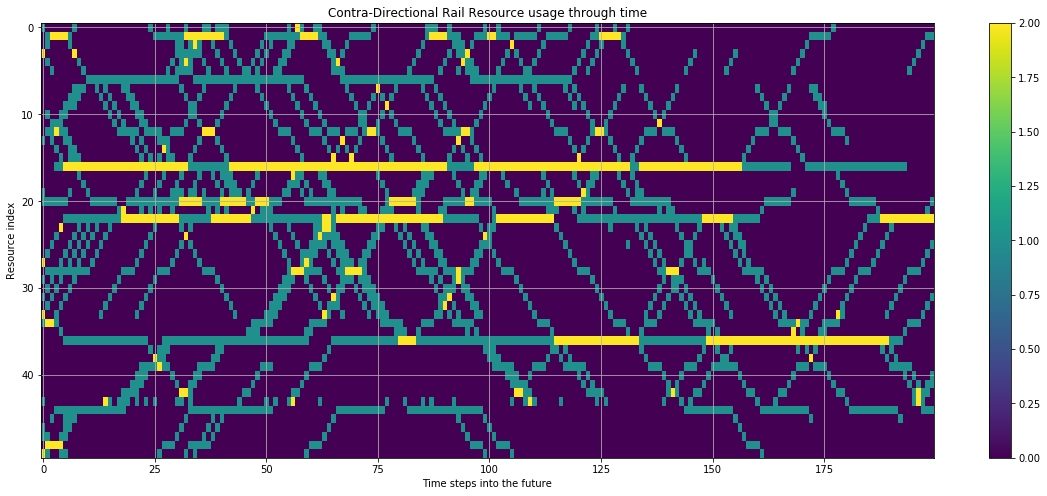

In [110]:
plt.figure(figsize=(20,8))
plt.imshow(a2ResDirSteps[:50,:200], aspect="auto")
#plt.scatter(35, 13, color="red")
plt.xlabel("Time steps into the future")
plt.ylabel("Resource index")
plt.colorbar()
plt.grid()
plt.title("Contra-Directional Rail Resource usage through time")

In [77]:
np.where(a2ResSteps > 2)

(array([103, 103, 111, 111, 111, 111, 111, 207, 207, 207, 207, 207, 207,
        207]), array([ 4,  5, 17, 18, 19, 20, 21, 64, 65, 66, 67, 68, 69, 70]))

In [78]:
list(dResource.keys())[57]

(35, 79)

In [79]:
if False:

    for i, lnPath in enumerate(llnGridPaths):
        #print(len(lnPath))
        print(i, len(lnPath), (23,50) in lnPath)
        #g2Path = array(lnPath)
        #plt.scatter(*g2Path.T, alpha=0.3)


### Generating k shortest paths does not appear to explore much

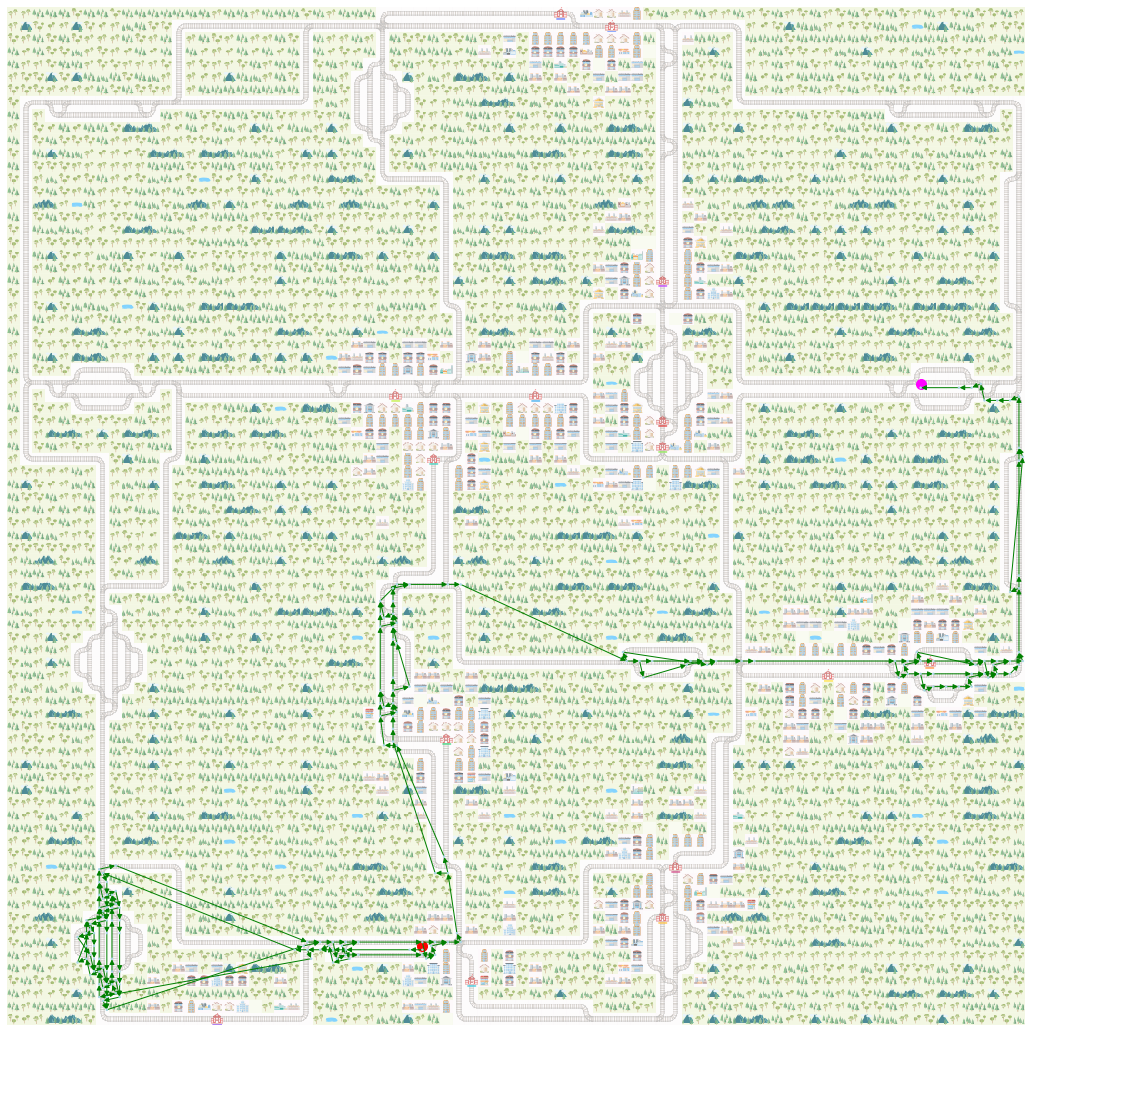

In [92]:
if True:
    

    for nStart, nEnd in zip(lnStart[0:1], lnTarget[0:1]):
    #for iPath, tPath in enumerate(nx.algorithms.shortest_simple_paths(G2, (0,25,0), (1,30,1))):
        lGpaths = []
        genPath = nx.algorithms.shortest_simple_paths(G, nStart, nEnd, weight="l")
        #genPath = nx.algorithms.all_simple_paths(G, nStart, nEnd)
        
        for iPath, tPath in enumerate(genPath):
            if iPath >= 200: break
            g2Path = array(tPath)
            # plt.scatter(g2Path[:, 1], -g2Path[:, 0], label=str(len(tPath)))
            Gpath = nx.induced_subgraph(G, tPath)
            lGpaths.append(Gpath)
        
        Gpaths = nx.compose_all(lGpaths)
        gu.plotGraphEnv(Gpaths, env2, aImg, node_size=2, figsize=(20,20), alpha_img=0.7)
        
        plt.scatter(nStart[1], -nStart[0], color="r", s=100)
        plt.scatter(nEnd[1], -nEnd[0], color="magenta", s=100)

    #plt.legend()

In [81]:
set([len(Gpath) for Gpath in lGpaths])

{69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79}

In [82]:
#[ (u, v, d["l"]) for u,v,d in Gpath.edges(data=True) ]

In [83]:
#[ (u, v, d) for u,v,d in G.edges(data=True) ]

### Follow the shortest path, and at each decision, generate the shortest path for the diversion

Start, End: (73, 32, 3) (29, 71, 3)
(73, 26, 3) (29, 71, 3)
(73, 23, 3) (29, 71, 3)
(77, 7, 0) (29, 71, 3)
(75, 7, 0) (29, 71, 3)
(70, 7, 0) (29, 71, 3)
(67, 7, 0) (29, 71, 3)
(73, 25, 1) (29, 71, 3)
(73, 32, 1) (29, 71, 3)
(73, 35, 1) (29, 71, 3)
(67, 34, 3) (29, 71, 3)
(55, 29, 0) (29, 71, 3)
(48, 29, 0) (29, 71, 3)
(45, 34, 1) (29, 71, 3)
(51, 48, 1) (29, 71, 3)
(51, 57, 1) (29, 71, 3)
(51, 69, 1) (29, 71, 3)
(51, 71, 1) (29, 71, 3)
(51, 76, 1) (29, 71, 3)
(45, 79, 0) (29, 71, 3)


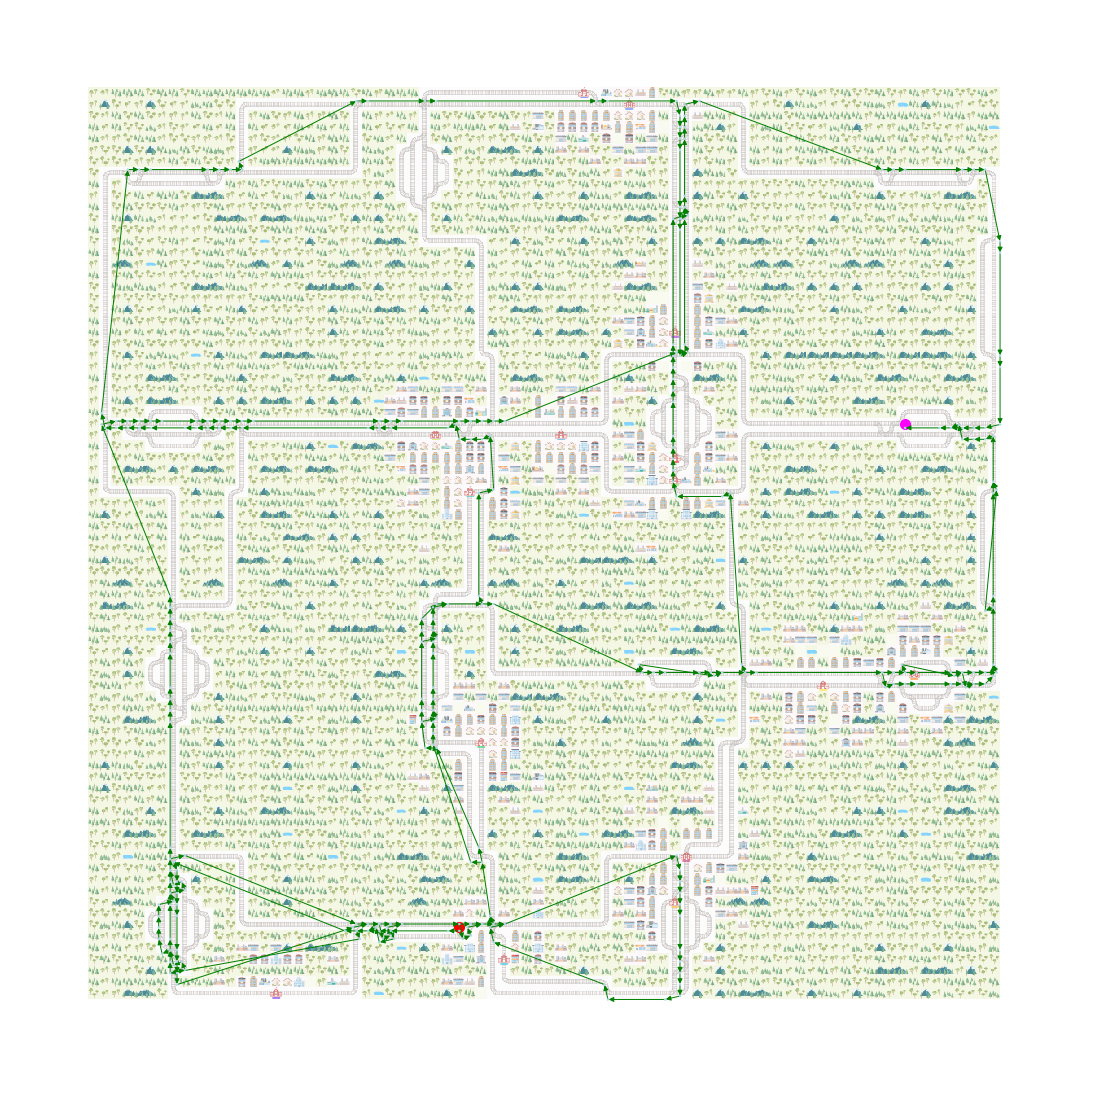

In [84]:
for nStart, nEnd in zip(lnStart[:1], lnTarget[:1]):
#for iPath, tPath in enumerate(nx.algorithms.shortest_simple_paths(G2, (0,25,0), (1,30,1))):
    lGpaths = []
    llnPaths = []
    print("Start, End:", nStart, nEnd)
    genPath = nx.algorithms.shortest_simple_paths(G, nStart, nEnd)
    #genPath = nx.algorithms.all_simple_paths(G, nStart, nEnd)

    for iPath, tPath in enumerate(genPath):
        if iPath >= 1: break
        g2Path = array(tPath)
        # plt.scatter(g2Path[:, 1], -g2Path[:, 0], label=str(len(tPath)))
        Gpath = nx.induced_subgraph(G, tPath).copy()
        lGpaths.append(Gpath)
        
        for iStepStart in range(1, len(tPath)-5):
            tPath2 = tPath[iStepStart:]
          
            # Start of the path
            n = tPath2[0]
            
            # If not a decision node, skip
            if len(G[n]) < 2:
                continue
            #print("Choices at step {} - {}".format(iStepStart, len(G[n])))
            
            # Next node in the shortest path
            n2 = tPath2[1]
            #print(n, n2, G[n])
            lSucc = set(G[n])
            lSucc.remove(n2)  # remove the next node in the shortest path
            nStart2 = lSucc.pop() # retrieve the other choice - the deviation
            
            genPath2 = nx.algorithms.shortest_simple_paths(G, nStart2, nEnd, weight="l")
            tPath3 = [n] + genPath2.__next__()
            print(tPath3[0], tPath3[-1])
            Gpath = nx.induced_subgraph(G, tPath3)
            lGpaths.append(Gpath)
            
            llnPaths.append(tPath3)
            
            

    Gpaths = nx.compose_all(lGpaths)


    
gu.plotGraphEnv(Gpaths, env2, aImg, node_size=2, figsize=(20,20), alpha_img=0.7)

plt.scatter(nStart[1], -nStart[0], color="r", s=100)
plt.scatter(nEnd[1], -nEnd[0], color="magenta", s=100)

# 73 35,  73 36
#plt.scatter(35, -73, color="yellow", s=100)
#plt.scatter(36, -73, color="yellow", s=100)

In [85]:
#gu.plotGraphEnv(nx.DiGraph([]), env=env2, aImg=aImg, alpha_img=1, figsize=(20,20))

In [86]:
[len(lnPath) for lnPath in llnPaths ]

[73, 68, 68, 68, 63, 60, 56, 53, 65, 46, 43, 38, 75, 30, 42, 23, 20, 18, 12]

In [87]:
[ sum([ d["l"] for u,v,d in nx.induced_subgraph(G, lnPath).edges(data=True) ]) for lnPath in llnPaths ]

[191,
 186,
 164,
 162,
 157,
 186,
 130,
 123,
 176,
 111,
 96,
 89,
 237,
 61,
 120,
 42,
 38,
 35,
 26]

In [88]:
if False: 
    for Gpath in lGpaths:
        plt.figure()
        nx.draw_spring(Gpath, with_labels=True, iterations=10000)

#gu.plotGraphEnv(Gpath, env2, aImg, node_size=2, figsize=(20,20), alpha_img=0.7)

In [89]:
Gpath.edges[(73,35,1), list(Gpath.successors((73,35,1)))[0]]

NetworkXError: The node (73, 35, 1) is not in the digraph.

In [ ]:
print(set([len(Gpath) for Gpath in lGpaths]))

In [ ]:
gEnv.savejson("Gpaths.json", alt_graph=Gpaths, bKeepId=True)

## Hammock topology
All roads lead to Rome!

We can take alternative routes but ultimately we need to end up at the target.

So a tree appears to grow unnecessarily.

However it's unclear how to handle the recombination in a fixed topology suitable for a fixed observation.


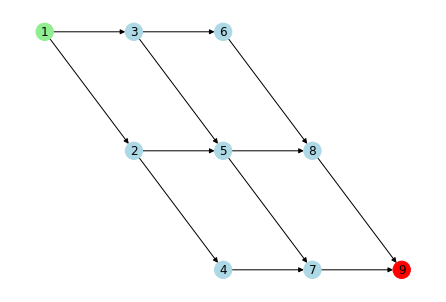

In [93]:
lHammock = [[1,2],[1,3],                  # 2, 3
            [2,4],[2,5], [3,5],[3,6],     # 4, 5, 6
            [4,7],[5,7], [5,8], [6,8],    # 7, 8
            [7,9],[8,9]
           ]
Gh = nx.DiGraph(lHammock)
lb="lightblue"
nx.draw(Gh, with_labels=True, fixed=[1,9], pos={1:[0,4], 2:[1,3], 3:[1,4], 4:[2,2], 5:[2,3], 6:[2,4], 7:[3,2], 8:[3,3], 9:[4,2]},
       node_color = ["lightgreen", lb, lb, lb, lb, lb, lb, lb, "r"])

In [ ]:
env = RailEnv(width=20, height=20, rail_generator=empty_rail_generator(), number_of_agents=0,
                          obs_builder_object=TreeObsForRailEnv(max_depth=2))
mvc = EditorMVC(sGL="PILSVG", env=env ) 

In [ ]:
mvc.view.display()

In [ ]:
env_renderer = RenderTool(env, gl="PILSVG",  screen_width=1200, screen_height=1200)
env_renderer.render_env(show=False, show_observations=False,)
aImg = env_renderer.gl.get_image()
#Image.fromarray(aImg)
# Create a grid of nodes matching (isomorphic to) the env rail grid
gEnv = RailEnvGraph(env)

G = gEnv.reduce_simple_paths()

In [ ]:
#plotGraphEnv(gEnv2.G, env2, aImg, figsize=(20,20))
gu.plotGraphEnv(G, env, aImg, figsize=(15,15), node_size=10,
                node_colors={"rail":"blue", "grid":"red"},
                edge_colors={"hold":"gray", "dir":"green"},
                show_nodes=("rail", "grid"),
                show_edges=("dir", "hold")
               )

gEnv.savejson(filename="editor_graph.json", alt_graph=G)